## QCLab: Kitaev’s Phase Estimation — QPE

In this lab we explore **Kitaev’s Phase Estimation** algorithm, a fundamental tool in quantum computing for extracting eigenphases of unitary operators. Suppose a unitary operator $U$ has an eigenstate $\lvert u \rangle$ with eigenvalue  
$$
U \lvert u \rangle = e^{2 \pi i \phi} \lvert u \rangle ,
$$  
where $\phi \in [0,1)$ is the normalized phase (fraction of a full $2\pi$ rotation).  

The goal of phase estimation is to determine $\phi$ by using controlled applications of $U^{2^k}$ and measurements on control qubits. For $n$ control qubits, we obtain an $n$-bit binary estimate of $\phi$.  

![Kitaev-QPE](images/Kitaev-QPE.png)
---

### Task
                 
- Based on the general QPE circuit design, the task is to implement a 2-qubit QPE circuit for the single-qubit phase gate $P(\theta)$, using the eigenstate $\lvert 1 \rangle$ as the target qubit, where $\theta = 2\pi\phi$.
- To calculate the phase angle, use the argmax (grid snap) method. The algorithm takes the measurement counts from a QPE run, finds the most likely control register outcome, converts it into an integer $y$, and returns the normalized phase estimate $\hat{\phi} = y/2^n.$<br>
Thus, the argmax method provides a discrete approximation of the true phase $\phi$, accurate to within $\pm1/2^n$.                

### Expected Output

- A plot of the QPE circuit.
- The true and estimated values of $\phi$, reported both in normalized form ($\phi \in [0,1)$) and in radians ($\theta = 2\pi\phi$).


### Experimentation

- Extend your circuit to 3 control qubits to increase the precision of phase estimation.  
- Replace the $P(\theta)$ gate with another unitary operator $U$ (for example, a $Z$-rotation) and verify that the circuit still extracts the correct eigenphase.  
- Add another function for calculating the phase from the measurement counts using the **circular mean** method instead of argmax. 


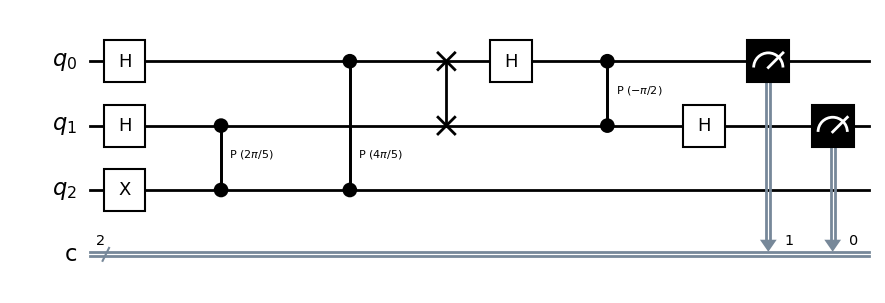

True φ     : 0.200000  (angle = 1.256637 rad)
Estimated φ: 0.250000  (angle = 1.570796 rad)


In [1]:
# ====================================================
# QCLab: Kitaev’s Phase Estimation — QPE
# <QC|CT> qcict.org
# ====================================================

from IPython.display import display
import numpy as np

from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer
from qiskit_aer import AerSimulator

# ---------- 2-qubit inverse QFT  ----------
def iqft2():
    iq = QuantumCircuit(2,)
    iq.swap(0, 1)              # restore MSB..LSB order
    iq.h(0)
    iq.cp(-np.pi/2, 1, 0)
    iq.h(1)
    return iq

# ---------- QPE circuit for U = P(2πφ) with 2 controls ----------
def qpe2(phi: float):
    """
    Control qubits: q0=c1 (MSB), q1=c0 (LSB). Target q2 starts in |1>.
    Measures controls into 2 classical bits [c0 (LSB), c1 (MSB)] -> read as b1 b0.
    """
    theta = 2*np.pi*phi
    qc = QuantumCircuit(3, 2)
    c1, c0, t = 0, 1, 2

    # Prepare target eigenstate |1>
    qc.x(t)

    # Superpose controls
    qc.h(c1)
    qc.h(c0)

    # Controlled U^{2^k} with U = P(theta)
    qc.cp(theta,  c0, t)      # LSB applies U^1
    qc.cp(2*theta, c1, t)     # MSB applies U^2

    # Inverse QFT on controls (with swaps so order is MSB..LSB)
    qc.compose(iqft2(),inplace=True)

    # Measure controls: store MSB in clbit 1, LSB in clbit 0
    qc.measure(c1, 1)
    qc.measure(c0, 0)
    return qc

# ----- Simple argmax (grid snap) phase estimation from counts ----
def argmax_phi(counts):
    """
    Selects the most frequent outcome, interprets it as an integer y,
    and returns φ̂ = y / 2^n where n is the number of control qubits.
    """
    y_str = max(counts, key=counts.get)        # most frequent outcome
    n = len(y_str)                             # number of control qubits
    y = int(y_str, 2)
    return y / (2**n)

# ------------------------------------------------
#                main program
# ------------------------------------------------

phi_true = 0.2  # normalized phase in [0,1)
qc = qpe2(phi_true)
display(circuit_drawer(qc, style="bw", output="mpl"))

# Run simulation
simulator = AerSimulator()
result = simulator.run(qc, shots=1024).result()
counts = result.get_counts()
phi_est = argmax_phi(counts)
    
print(f"True φ     : {phi_true:.6f}  (angle = {2*np.pi*phi_true:.6f} rad)")
print(f"Estimated φ: {phi_est:.6f}  (angle = {2*np.pi*phi_est:.6f} rad)")